In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

/srv/conda/envs/py36/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


In [2]:
def load_hcp100_bold(path, subjects=range(1, 101)):
    """
    Loads the BOLD data of the HCP100 dataset.
    
    Parameters
    ----------
    path : str
           path to data folder

    subjects : iterable
               iterable with ids of subjects to be loaded
               by default, all 100 subjects will be loaded
             
    Returns
    -------
    data : list of 2d nd arrays
           synthetic BOLD time series (numTRs X numROIs) of n subjects
           output format matches nilearn.ConnectivityMeasure.fit_transform() input format
    """
    data = []
    for sub in subjects:
        fullfile = os.path.join(path, f"sub{sub:03}_BOLD_timeseries_HCP.csv")
        data.append(np.asarray(pd.read_csv(fullfile, header=None)).transpose())
        
    return data

In [3]:
# load BOLD data and structural connectivity
path = "/home/jovyan/shared/hcp_connectivity/schaefer100"
empirical_bold = load_hcp100_bold(path)
print(f"empirical BOLD data shape: {empirical_bold[0].shape}")

empirical BOLD data shape: (1189, 100)


In [4]:
# ignore nilearn warning messages
import warnings
warnings.filterwarnings("ignore", message="The default strategy for standardize is currently 'zscore'")

# compute vectorized functional connectivity matrix: numEdges x numSubs
conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
empirical_FC = conn_measure.fit_transform(empirical_bold).transpose()
print(f"empirical FC shape: {empirical_FC.shape}")

empirical FC shape: (4950, 100)


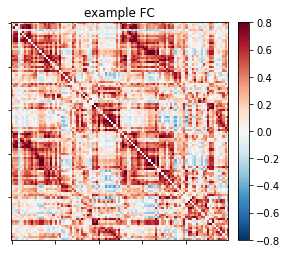

In [5]:
# plot example FC and SC
from nilearn import plotting

conn_measure2d = ConnectivityMeasure(kind='correlation', vectorize=False, discard_diagonal=False)
exampleFC = conn_measure2d.fit_transform([empirical_bold[0]]).squeeze()
np.fill_diagonal(exampleFC, 0)

fig, ax = plt.subplots();
im = plotting.plot_matrix(exampleFC, vmax=0.8, vmin=-0.8, colorbar=False, axes=ax);
plt.colorbar(im, fraction=0.05, pad=0.03);
ax.set_title("example FC");
plt.show()

In [6]:
# import fMRIsynth library :)
from fMRIsynth.fMRIsynth import synthesize_subjects
from fMRIsynth import BrainModel

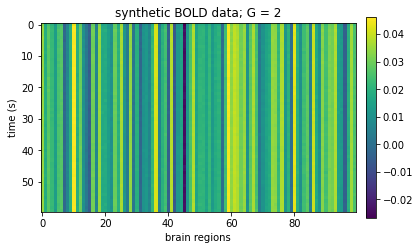

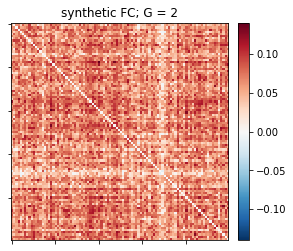

In [7]:
# test run the consensus structural connectivity
ms = 120000
model = BrainModel()
model.testrun(ms)

In [8]:
# test: fit model to empirical FC of random subject
import time

exampleSub = 29

start = time.time()
model = BrainModel()
model.fit(empirical_FC[:, exampleSub], ms=120000, init_points=5, n_iter=25)
end = time.time()
print(f"time passed: {(end-start)/60} minutes.")

|   iter    |  target   |     G     |
-------------------------------------
| 1         | -45.7     | 1.354     |
| 2         | -53.31    | 4.02      |
| 3         | -53.68    | 4.647     |
| 4         | -45.54    | 1.081     |
| 5         | -50.02    | 2.291     |
| 6         | -47.94    | 0.01      |
| 7         | -47.92    | 0.7528    |
| 8         | -52.2     | 3.075     |
| 9         | -42.12    | 1.697     |
| 10        | -54.85    | 1.678     |
| 11        | -47.6     | 0.7528    |
| 12        | -36.32    | 1.697     |
| 13        | -51.29    | 1.698     |
| 14        | -44.28    | 1.08      |
| 15        | -52.38    | 1.697     |
| 16        | -46.34    | 1.08      |
| 17        | -50.57    | 0.7525    |
| 18        | -43.74    | 1.08      |
| 19        | -45.35    | 1.697     |
| 20        | -47.33    | 1.08      |
| 21        | -45.49    | 1.081     |
| 22        | -44.2     | 1.081     |
| 23        | -49.31    | 1.697     |
| 24        | -43.56    | 1.354     |
| 25        

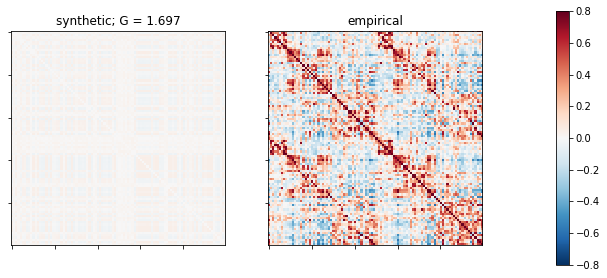

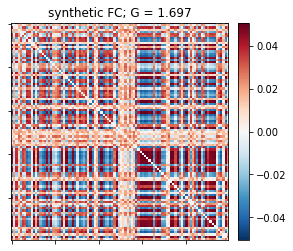

In [9]:
# visual assessment of model fit

# synthesize BOLD data
timesteps = 120000 # miliseconds
bold = model.run(timesteps)

# compute synthetic FC
FCsynth = conn_measure2d.fit_transform([bold.transpose()]).squeeze()
np.fill_diagonal(FCsynth, 0)

# compute empirical FC of sub0
FCemp = conn_measure2d.fit_transform([empirical_bold[exampleSub]]).squeeze()

# plot synthetic and empirical FC next to each other
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 22));
plotting.plot_matrix(FCsynth, vmax=0.8, vmin=-0.8, colorbar=False, axes=ax0);
plotting.plot_matrix(FCemp, vmax=0.8, vmin=-0.8, colorbar=True, axes=ax1);
ax0.set_title(f"synthetic; G = {np.round(model.get_G(), 3)}");
ax1.set_title('empirical');

# plot synthetic once again with different colour range
fig, ax = plt.subplots();
scaling = np.max(FCsynth) if np.max(FCsynth)>(-np.min(FCsynth)) else (-np.min(FCsynth))
im = plotting.plot_matrix(FCsynth, vmax=scaling, vmin=-scaling, colorbar=False, axes=ax);
plt.colorbar(im, fraction=0.05, pad=0.03);
ax.set_title(f"synthetic FC; G = {np.round(model.get_G(), 3)}");
plt.show()

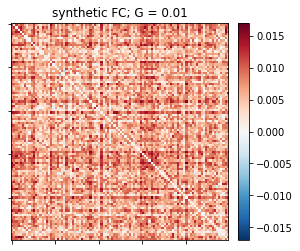

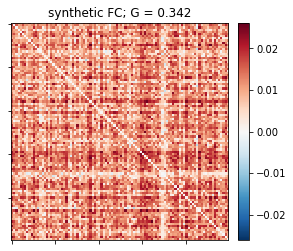

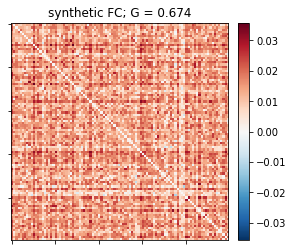

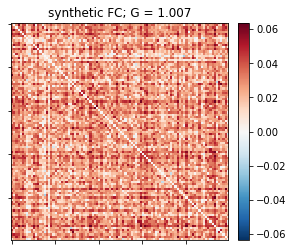

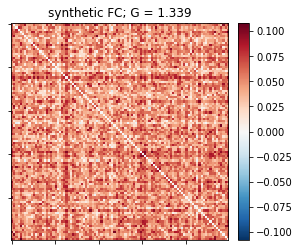

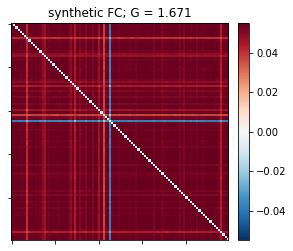

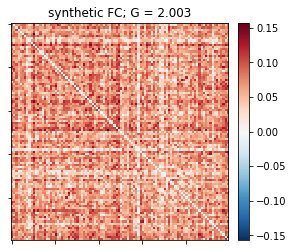

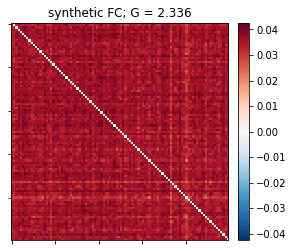

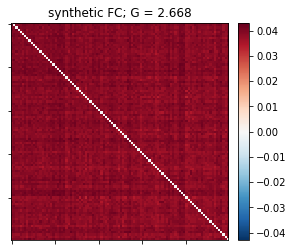

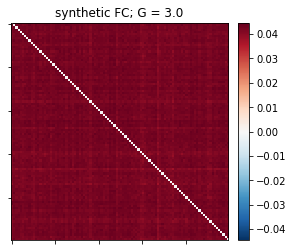

In [10]:
# try a range of different Gs for exampleSub
ms = 120000
Gs = np.linspace(0.01, 3, 10)
for g in Gs:
    model = BrainModel()
    model.testrun(ms, G=g, plots=[0,1])